Dans ce notebook, nous allons parcourir les autres dataframe et créer beaucoup de nouvelles variables par aggrégation numériques et catégorielles. Pour plus de lisibilité, beaucoup des fonctions utilisés ici sont dans le fichier `.\Utils\functions.py` comme `agg_categorical` ou `agg_numeric`.  
La stratégie ici est de regrouper les données numériques des précedents prêts par client, de leur appliquer plusieurs oppération ('count', 'mean', 'max', 'min', 'sum') avant de les rapatrier dans le jeu de donnée principal. Pour les variables catégorielles, on applique un encoding, et on calculera un count et un count normalisé pour chacune des valeurs possible de cette variable catégorielle.  
Ici on ne cherche plus à expliquer les variables les une après les autres, certainnes seront meme très difficilement interprétables, mais elles auront tout de même une chance de jouer un role dans notre modeling plus tard. 

In [2]:
# File system manangement
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

# my utility functions, see functions.py
from Utils.functions import *

In [3]:
df_app_train = pd.read_csv('df_engineered/df_app_train.csv')
df_app_test = pd.read_csv('df_engineered/df_app_test.csv')

#df_app_train = pd.read_csv('df_engineered/df_app_train_poly_domain.csv')
#df_app_test = pd.read_csv('df_engineered/df_app_test_poly_domain.csv')

In [4]:
df_bureau = pd.read_csv('data/bureau.csv')
df_bureau_balance = pd.read_csv('data/bureau_balance.csv')
df_prev_app = pd.read_csv('data/previous_application.csv')
df_POS_CASH_balance = pd.read_csv('data/POS_CASH_balance.csv')
df_credit_card_balance = pd.read_csv('data/credit_card_balance.csv')
df_instal_payments = pd.read_csv('data/installments_payments.csv')

Gros gain de mémoire ici :

In [5]:
gc.enable()

df_app_train = convert_types(df_app_train, print_info = True)
print('-------------------------')
df_app_test = convert_types(df_app_test, print_info = True)
print('-------------------------')
df_bureau = convert_types(df_bureau, print_info = True)
print('-------------------------')
df_bureau_balance = convert_types(df_bureau_balance, print_info = True)
print('-------------------------')
df_prev_app = convert_types(df_prev_app, print_info = True)
print('-------------------------')
df_credit_card_balance = convert_types(df_credit_card_balance, print_info = True)
print('-------------------------')
df_instal_payments = convert_types(df_instal_payments, print_info = True)
print('-------------------------')
df_POS_CASH_balance = convert_types(df_POS_CASH_balance, print_info = True)
print('-------------------------')

gc.collect()

Original Memory Usage: 0.31 gb.
New Memory Usage: 0.23 gb.
-------------------------
Original Memory Usage: 0.05 gb.
New Memory Usage: 0.04 gb.
-------------------------
Original Memory Usage: 0.23 gb.
New Memory Usage: 0.13 gb.
-------------------------
Original Memory Usage: 0.66 gb.
New Memory Usage: 0.35 gb.
-------------------------
Original Memory Usage: 0.49 gb.
New Memory Usage: 0.19 gb.
-------------------------
Original Memory Usage: 0.71 gb.
New Memory Usage: 0.42 gb.
-------------------------
Original Memory Usage: 0.87 gb.
New Memory Usage: 0.49 gb.
-------------------------
Original Memory Usage: 0.64 gb.
New Memory Usage: 0.41 gb.
-------------------------


0

## Autres dataframes :


### `bureau`

In [6]:
print(df_bureau.shape)
df_bureau.head()

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [7]:
print(df_bureau_balance.shape)
df_bureau_balance.head()

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


#### Nombre de prêt(s) précédent `previous_loan_counts`

In [8]:
previous_loan_counts = df_bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [9]:
df_app_train_temp = df_app_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
df_app_test_temp = df_app_test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

df_app_train_temp['previous_loan_counts'] = df_app_train_temp['previous_loan_counts'].fillna(0)
df_app_test_temp['previous_loan_counts'] = df_app_test_temp['previous_loan_counts'].fillna(0)

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


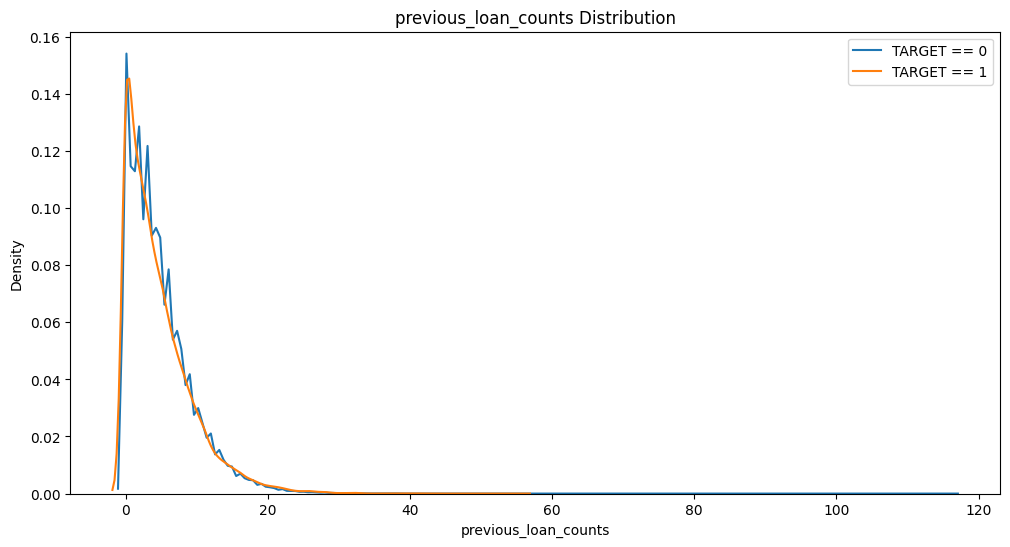

In [10]:
kde_target('previous_loan_counts', df_app_train_temp)

Peu de chance que cette variable joue un role dans nos algorithmes de machine learning.

In [11]:
#df_app_train = df_app_train_temp
#df_app_test = df_app_test_temp

### Aggrégation des variables numériques

In [12]:
bureau_agg = agg_numeric(df_bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357178,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [13]:
df_app_train_temp = df_app_train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
df_app_test_temp = df_app_test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

On vérifie les corrélations :

In [14]:
new_corrs = target_corrs(df_app_train_temp, bureau_agg.columns)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.089728967219981),
 ('bureau_DAYS_CREDIT_min', 0.07524825103010374),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968684),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.055887379843920795),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.053734895601020585),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962580092951),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997309),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611115936),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275436796515),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073023),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484667),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.0414036353530601),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632898),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921615996),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665332547)]

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


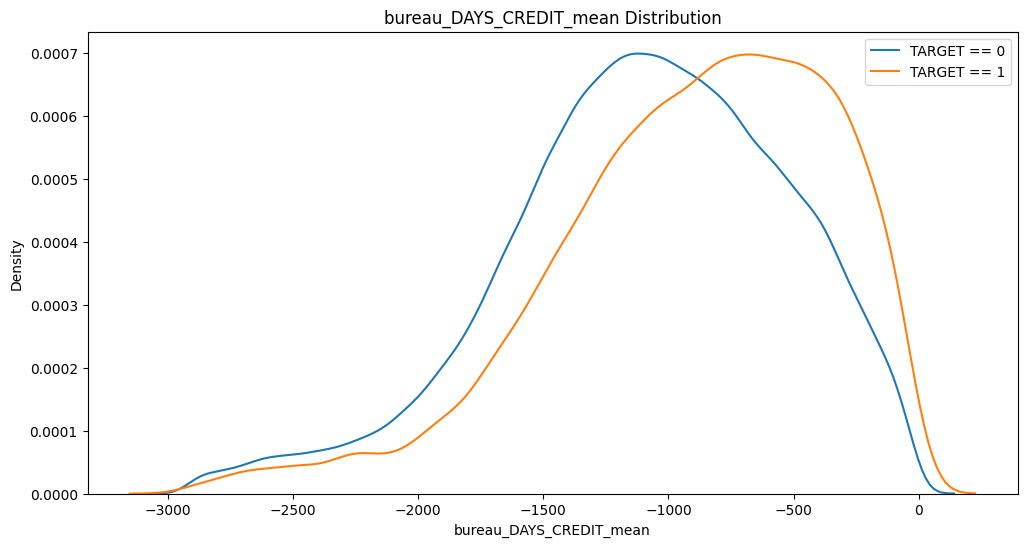

In [15]:
kde_target('bureau_DAYS_CREDIT_mean', df_app_train_temp)

> #### !!!! The Multiple Comparisons Problem  
> When we have lots of variables, we expect some of them to be correlated just by pure chance, a problem known as multiple comparisons. We can make hundreds of features, and some will turn out to be corelated with the target simply because of random noise in the data. Then, when our model trains, it may overfit to these variables because it thinks they have a relationship with the target in the training set, but this does not necessarily generalize to the test set. There are many considerations that we have to take into account when making features!


In [16]:
df_app_train = df_app_train_temp
df_app_test = df_app_test_temp

In [17]:
gc.enable()
del bureau_agg, previous_loan_counts
gc.collect()

3631

### Variables catégorielles

In [18]:
df_bureau_categorical_grouped = agg_categorical(df_bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
df_bureau_categorical_grouped.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [19]:
df_app_train_temp = df_app_train.merge(df_bureau_categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
df_app_test_temp = df_app_test.merge(df_bureau_categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')

df_app_train_temp.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
new_corrs = target_corrs(df_app_train_temp, df_bureau_categorical_grouped.columns)
new_corrs[:15]

[('bureau_CREDIT_ACTIVE_Closed_count_norm', -0.07936887408889627),
 ('bureau_CREDIT_ACTIVE_Active_count_norm', 0.07735577958544369),
 ('bureau_CREDIT_ACTIVE_Active_count', 0.06712815345642878),
 ('bureau_CREDIT_TYPE_Microloan_count_norm', 0.04443943809087851),
 ('bureau_CREDIT_TYPE_Credit card_count', 0.03481781990538232),
 ('bureau_CREDIT_TYPE_Credit card_count_norm', 0.03468405774232279),
 ('bureau_CREDIT_TYPE_Microloan_count', 0.03411049827421553),
 ('bureau_CREDIT_ACTIVE_Closed_count', -0.030812408184358746),
 ('bureau_CREDIT_TYPE_Consumer credit_count_norm', -0.026258496023451677),
 ('bureau_CREDIT_TYPE_Mortgage_count', -0.023306648977252577),
 ('bureau_CREDIT_TYPE_Mortgage_count_norm', -0.02086745745636147),
 ('bureau_CREDIT_TYPE_Car loan_count', -0.020816695387449142),
 ('bureau_CREDIT_TYPE_Car loan_count_norm', -0.020134386805691875),
 ('bureau_CREDIT_ACTIVE_Sold_count_norm', 0.016530032076331976),
 ('bureau_CREDIT_ACTIVE_Sold_count', 0.012057565591670007)]

In [21]:
df_app_train = df_app_train_temp
df_app_test = df_app_test_temp

In [22]:
gc.enable()
del df_bureau_categorical_grouped
gc.collect()

3427

### `bureau_balance`

In [23]:
df_bureau_balance.head(5)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [24]:
bureau_balance_counts = agg_categorical(df_bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [25]:
bureau_balance_agg = agg_numeric(df_bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


On merge les deux :

In [26]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
bureau_by_loan = bureau_by_loan.merge(df_bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [27]:
bureau_by_loan.dropna(subset = ['SK_ID_CURR'], inplace=True)
bureau_by_loan

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.000000,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.000000,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.000000,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.000000,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0
5,5001714,15,-7.0,0,-14,-105,0,0.000000,0,0.000000,...,0.0,0,0.0,0,0.0,0,0.000000,15,1.000000,150635.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817390,6842884,48,-23.5,0,-47,-1128,9,0.187500,0,0.000000,...,0.0,0,0.0,0,0.0,20,0.416667,19,0.395833,387020.0
817391,6842885,24,-11.5,0,-23,-276,12,0.500000,0,0.000000,...,0.0,0,0.0,12,0.5,0,0.000000,0,0.000000,387020.0
817392,6842886,33,-16.0,0,-32,-528,8,0.242424,0,0.000000,...,0.0,0,0.0,0,0.0,25,0.757576,0,0.000000,387020.0
817393,6842887,37,-18.0,0,-36,-666,6,0.162162,0,0.000000,...,0.0,0,0.0,0,0.0,31,0.837838,0,0.000000,387020.0


On re applique une aggregation par client

In [28]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client['SK_ID_CURR'] = bureau_balance_by_client['SK_ID_CURR'].astype(int)
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30,7,0.214590,0.500000,0.0,1.502129
1,100002,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15,8,0.161932,0.500000,0.0,1.295455
2,100005,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2,3,0.136752,0.333333,0.0,0.410256
3,100010,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0,2,0.000000,0.000000,0.0,0.000000
4,100013,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41,4,0.254545,1.000000,0.0,1.018182


In [29]:
df_app_train_temp = df_app_train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
df_app_test_temp = df_app_test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
df_app_train_temp.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,8.0,1.875,3.0,0.0,15.0,8.0,0.161932,0.5,0.0,1.295455
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
new_corrs = target_corrs(df_app_train_temp, bureau_balance_by_client.columns)
new_corrs[:15]

[('client_bureau_balance_MONTHS_BALANCE_min_mean', 0.08903758347314678),
 ('client_bureau_balance_MONTHS_BALANCE_count_mean', -0.08019279487546795),
 ('client_bureau_balance_MONTHS_BALANCE_mean_mean', 0.07642449076705929),
 ('client_bureau_balance_MONTHS_BALANCE_min_min', 0.07322455721449504),
 ('client_bureau_balance_MONTHS_BALANCE_sum_mean', 0.0726056804464597),
 ('client_bureau_balance_MONTHS_BALANCE_count_max', -0.06879166105216332),
 ('client_bureau_balance_MONTHS_BALANCE_sum_min', 0.06807162991867018),
 ('client_bureau_balance_STATUS_C_count_mean', -0.06295370415547608),
 ('client_bureau_balance_STATUS_1_count_norm_mean', 0.061182927384271474),
 ('client_bureau_balance_STATUS_1_count_norm_max', 0.06112196471275896),
 ('client_bureau_balance_STATUS_C_count_max', -0.06108336901635778),
 ('client_bureau_balance_STATUS_C_count_norm_mean', -0.055935796224900344),
 ('client_bureau_balance_MONTHS_BALANCE_sum_sum', 0.05381776148315999),
 ('client_bureau_balance_MONTHS_BALANCE_mean_min', 

In [31]:
df_app_train = df_app_train_temp
df_app_test = df_app_test_temp

In [32]:
gc.enable()
del bureau_balance_counts, bureau_balance_by_client, bureau_by_loan, bureau_balance_agg, df_bureau_balance, df_bureau
gc.collect()

0

### `previous_application`

Précedent crédit fait à Home Credit, il peut y avoir plusieurs `SK_ID_PREV` par `SK_ID_CURR`.  
1 ligne par `SK_ID_PREV`

In [33]:
df_prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


### Variables numériques

In [34]:
previous_agg = agg_numeric(df_prev_app, 'SK_ID_CURR', 'previous')
previous_agg.head()

,SK_ID_CURR,previous_AMT_ANNUITY_count,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_sum,previous_AMT_APPLICATION_count,previous_AMT_APPLICATION_mean,previous_AMT_APPLICATION_max,previous_AMT_APPLICATION_min,...,previous_DAYS_TERMINATION_count,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_sum,previous_NFLAG_INSURED_ON_APPROVAL_count,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000000,3951.000000,3951.000000,3951.000000,1,24835.50,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775391,9251.775391,9251.775391,9251.775391,1,179055.00,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.988281,98356.992188,6737.310059,169661.968750,3,435436.50,900000.0,68809.5,...,3,-1047.333374,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250000,5357.250000,5357.250000,5357.250000,1,24282.00,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,1,4813.200195,4813.200195,4813.200195,4813.200195,2,22308.75,44617.5,0.0,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0


In [35]:
df_app_train_temp = df_app_train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')
df_app_test_temp = df_app_test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')
df_app_train_temp.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,previous_DAYS_TERMINATION_count,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_sum,previous_NFLAG_INSURED_ON_APPROVAL_count,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_sum
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,1.0,-17.000000,-17.0,-17.0,-17.0,1.0,0.000000,0.0,0.0,0.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,3.0,-1047.333374,-527.0,-1976.0,-3142.0,3.0,0.666667,1.0,0.0,2.0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,1.0,-714.000000,-714.0,-714.0,-714.0,1.0,0.000000,0.0,0.0,0.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,4.0,182481.750000,365243.0,-416.0,729927.0,4.0,0.000000,0.0,0.0,0.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,5.0,72143.796875,365243.0,-2041.0,360719.0,5.0,0.600000,1.0,0.0,3.0


In [36]:
new_corrs = target_corrs(df_app_train_temp, previous_agg.columns)
new_corrs[:15]

[('previous_DAYS_DECISION_min', 0.053433694067675126),
 ('previous_DAYS_FIRST_DRAWING_mean', -0.04880258044064616),
 ('previous_DAYS_DECISION_mean', 0.04686436759886139),
 ('previous_DAYS_FIRST_DRAWING_min', -0.04464250985551043),
 ('previous_RATE_DOWN_PAYMENT_sum', -0.04169321676062506),
 ('previous_DAYS_FIRST_DRAWING_sum', -0.041671148719533216),
 ('previous_RATE_DOWN_PAYMENT_max', -0.04009582153939289),
 ('previous_HOUR_APPR_PROCESS_START_mean', -0.035927132111336614),
 ('previous_AMT_ANNUITY_mean', -0.03487077309917834),
 ('previous_RATE_DOWN_PAYMENT_mean', -0.03360081664572255),
 ('previous_AMT_ANNUITY_min', -0.0322486286183967),
 ('previous_DAYS_FIRST_DRAWING_count', -0.03183327162711627),
 ('previous_DAYS_FIRST_DUE_count', -0.03183327162711627),
 ('previous_DAYS_LAST_DUE_1ST_VERSION_count', -0.03183327162711627),
 ('previous_DAYS_LAST_DUE_count', -0.03183327162711627)]

In [37]:
df_app_train = df_app_train_temp
df_app_test = df_app_test_temp

In [38]:
gc.enable()
del previous_agg
gc.collect()

0

The correlation between previous_DAYS_DECISION_min and the TARGET is 0.0534
Median value for loan that was not repaid = -1201.0000
Median value for loan that was repaid =     -1523.0000


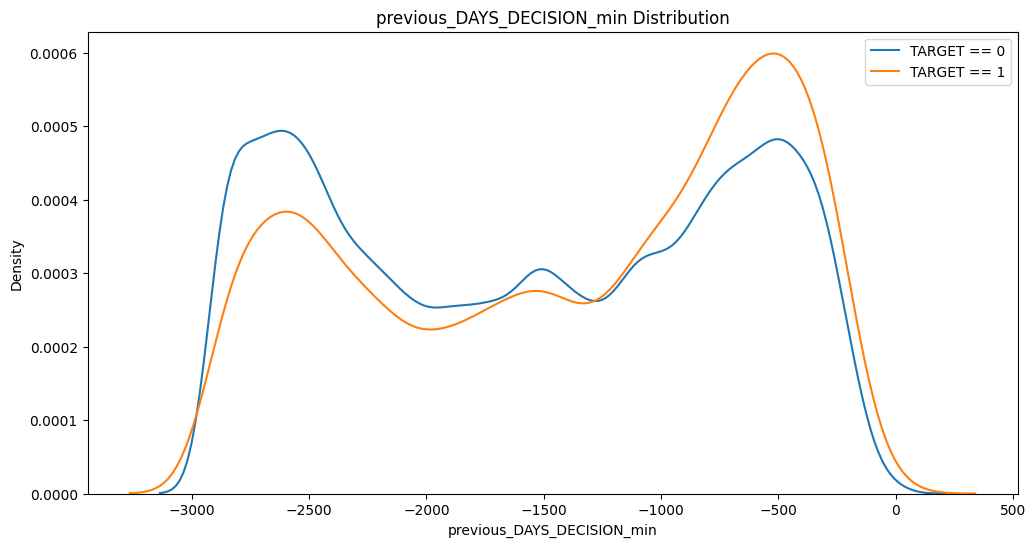

In [39]:
kde_target('previous_DAYS_DECISION_min', df_app_train)

### Variables catégorielles

In [40]:
previous_counts = agg_categorical(df_prev_app, 'SK_ID_CURR', 'previous')
previous_counts.head()

,previous_NAME_CONTRACT_TYPE_Cash loans_count,previous_NAME_CONTRACT_TYPE_Cash loans_count_norm,previous_NAME_CONTRACT_TYPE_Consumer loans_count,previous_NAME_CONTRACT_TYPE_Consumer loans_count_norm,previous_NAME_CONTRACT_TYPE_Revolving loans_count,previous_NAME_CONTRACT_TYPE_Revolving loans_count_norm,previous_NAME_CONTRACT_TYPE_XNA_count,previous_NAME_CONTRACT_TYPE_XNA_count_norm,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_count,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm,...,previous_PRODUCT_COMBINATION_POS industry without interest_count,previous_PRODUCT_COMBINATION_POS industry without interest_count_norm,previous_PRODUCT_COMBINATION_POS mobile with interest_count,previous_PRODUCT_COMBINATION_POS mobile with interest_count_norm,previous_PRODUCT_COMBINATION_POS mobile without interest_count,previous_PRODUCT_COMBINATION_POS mobile without interest_count_norm,previous_PRODUCT_COMBINATION_POS other with interest_count,previous_PRODUCT_COMBINATION_POS other with interest_count_norm,previous_PRODUCT_COMBINATION_POS others without interest_count,previous_PRODUCT_COMBINATION_POS others without interest_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
100002,0,0.000000,1,1.000000,0,0.0,0,0.0,0,0.000000,...,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
100003,1,0.333333,2,0.666667,0,0.0,0,0.0,1,0.333333,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
100005,1,0.500000,1,0.500000,0,0.0,0,0.0,1,0.500000,...,0,0.0,1,0.5,0,0.0,0,0.0,0,0.0


In [41]:
df_app_train_temp = df_app_train.merge(previous_counts, on = 'SK_ID_CURR', how = 'left')
df_app_test_temp = df_app_test.merge(previous_counts, on = 'SK_ID_CURR', how = 'left')
df_app_train_temp.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,previous_PRODUCT_COMBINATION_POS industry without interest_count,previous_PRODUCT_COMBINATION_POS industry without interest_count_norm,previous_PRODUCT_COMBINATION_POS mobile with interest_count,previous_PRODUCT_COMBINATION_POS mobile with interest_count_norm,previous_PRODUCT_COMBINATION_POS mobile without interest_count,previous_PRODUCT_COMBINATION_POS mobile without interest_count_norm,previous_PRODUCT_COMBINATION_POS other with interest_count,previous_PRODUCT_COMBINATION_POS other with interest_count_norm,previous_PRODUCT_COMBINATION_POS others without interest_count,previous_PRODUCT_COMBINATION_POS others without interest_count_norm
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.0,0.0,1.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
new_corrs = target_corrs(df_app_train_temp, previous_counts.columns)
new_corrs[:15]

[('previous_NAME_CONTRACT_STATUS_Refused_count_norm', 0.07767144969646207),
 ('previous_CODE_REJECT_REASON_XAP_count_norm', -0.0739300731279212),
 ('previous_NAME_CONTRACT_STATUS_Refused_count', 0.06446885905119594),
 ('previous_NAME_CONTRACT_STATUS_Approved_count_norm', -0.06352074883152309),
 ('previous_CODE_REJECT_REASON_SCOFR_count', 0.05628386046568038),
 ('previous_CODE_REJECT_REASON_SCOFR_count_norm', 0.05586467000053831),
 ('previous_CODE_REJECT_REASON_HC_count_norm', 0.054530993986016046),
 ('previous_PRODUCT_COMBINATION_Card Street_count', 0.04795288573228267),
 ('previous_CODE_REJECT_REASON_HC_count', 0.04706696907063798),
 ('previous_NAME_CLIENT_TYPE_New_count', 0.046047592880994546),
 ('previous_NAME_CONTRACT_TYPE_Revolving loans_count', 0.04560168096680161),
 ('previous_CODE_REJECT_REASON_LIMIT_count', 0.04050295082379217),
 ('previous_CODE_REJECT_REASON_LIMIT_count_norm', 0.0398417411658103),
 ('previous_NAME_PAYMENT_TYPE_XNA_count', 0.03946897030341551),
 ('previous_NAM

In [43]:
df_app_train = df_app_train_temp
df_app_test = df_app_test_temp

In [44]:
gc.enable()
del previous_counts, df_prev_app
gc.collect()

3428

### `Monthly Cash Data` / `POS_CASH_balance`

Comme nous travaillons ici avec plusieurs prêts par clients. Nous allons avoir besoin d'utiliser la fonction suivante, qui regroupe d'abord les information par prêt, puis ensuite par clients.

In [45]:
df_POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [46]:
cash_by_client = aggregate_client(df_POS_CASH_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

,SK_ID_CURR,client_cash_NAME_CONTRACT_STATUS_Active_count_count,client_cash_NAME_CONTRACT_STATUS_Active_count_mean,client_cash_NAME_CONTRACT_STATUS_Active_count_max,client_cash_NAME_CONTRACT_STATUS_Active_count_min,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_norm_count,client_cash_NAME_CONTRACT_STATUS_Active_count_norm_mean,client_cash_NAME_CONTRACT_STATUS_Active_count_norm_max,client_cash_NAME_CONTRACT_STATUS_Active_count_norm_min,...,client_cash_SK_DPD_DEF_min_count,client_cash_SK_DPD_DEF_min_mean,client_cash_SK_DPD_DEF_min_max,client_cash_SK_DPD_DEF_min_min,client_cash_SK_DPD_DEF_min_sum,client_cash_SK_DPD_DEF_sum_count,client_cash_SK_DPD_DEF_sum_mean,client_cash_SK_DPD_DEF_sum_max,client_cash_SK_DPD_DEF_sum_min,client_cash_SK_DPD_DEF_sum_sum
0,100001,9,3.555556,4,3,32,9,0.777778,0.800000,0.750000,...,9,0.0,0,0,0,9,3.111111,7,0,28
1,100002,19,19.000000,19,19,361,19,1.000000,1.000000,1.000000,...,19,0.0,0,0,0,19,0.000000,0,0,0
2,100003,28,9.142857,12,7,256,28,0.928571,1.000000,0.875000,...,28,0.0,0,0,0,28,0.000000,0,0,0
3,100004,4,3.000000,3,3,12,4,0.750000,0.750000,0.750000,...,4,0.0,0,0,0,4,0.000000,0,0,0
4,100005,11,9.000000,9,9,99,11,0.818182,0.818182,0.818182,...,11,0.0,0,0,0,11,0.000000,0,0,0


In [47]:
df_app_train_temp = df_app_train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
df_app_test_temp = df_app_test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
df_app_train_temp.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,client_cash_SK_DPD_DEF_min_count,client_cash_SK_DPD_DEF_min_mean,client_cash_SK_DPD_DEF_min_max,client_cash_SK_DPD_DEF_min_min,client_cash_SK_DPD_DEF_min_sum,client_cash_SK_DPD_DEF_sum_count,client_cash_SK_DPD_DEF_sum_mean,client_cash_SK_DPD_DEF_sum_max,client_cash_SK_DPD_DEF_sum_min,client_cash_SK_DPD_DEF_sum_sum
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,19.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,28.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,21.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,66.0,0.0,0.0,0.0,0.0,66.0,0.0,0.0,0.0,0.0


In [48]:
new_corrs = target_corrs(df_app_train_temp, cash_by_client.columns)
new_corrs[:15]

[('client_cash_MONTHS_BALANCE_min_min', 0.05530732656409646),
 ('client_cash_NAME_CONTRACT_STATUS_Active_count_norm_sum',
  -0.03586594503332478),
 ('client_cash_NAME_CONTRACT_STATUS_Active_count_count', -0.03563197385243185),
 ('client_cash_NAME_CONTRACT_STATUS_Active_count_norm_count',
  -0.03563197385243185),
 ('client_cash_NAME_CONTRACT_STATUS_Amortized debt_count_count',
  -0.03563197385243185),
 ('client_cash_NAME_CONTRACT_STATUS_Amortized debt_count_norm_count',
  -0.03563197385243185),
 ('client_cash_NAME_CONTRACT_STATUS_Approved_count_count',
  -0.03563197385243185),
 ('client_cash_NAME_CONTRACT_STATUS_Approved_count_norm_count',
  -0.03563197385243185),
 ('client_cash_NAME_CONTRACT_STATUS_Canceled_count_count',
  -0.03563197385243185),
 ('client_cash_NAME_CONTRACT_STATUS_Canceled_count_norm_count',
  -0.03563197385243185),
 ('client_cash_NAME_CONTRACT_STATUS_Completed_count_count',
  -0.03563197385243185),
 ('client_cash_NAME_CONTRACT_STATUS_Completed_count_norm_count',
  -0.

In [49]:
df_app_train = df_app_train_temp
df_app_test = df_app_test_temp

In [50]:
gc.enable()
del cash_by_client, df_POS_CASH_balance
gc.collect()

0

### `Monthly Credit Data` / `credit card balance`

In [51]:
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [52]:
credit_by_client = aggregate_client(df_credit_card_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,SK_ID_CURR,client_credit_NAME_CONTRACT_STATUS_Active_count_count,client_credit_NAME_CONTRACT_STATUS_Active_count_mean,client_credit_NAME_CONTRACT_STATUS_Active_count_max,client_credit_NAME_CONTRACT_STATUS_Active_count_min,client_credit_NAME_CONTRACT_STATUS_Active_count_sum,client_credit_NAME_CONTRACT_STATUS_Active_count_norm_count,client_credit_NAME_CONTRACT_STATUS_Active_count_norm_mean,client_credit_NAME_CONTRACT_STATUS_Active_count_norm_max,client_credit_NAME_CONTRACT_STATUS_Active_count_norm_min,...,client_credit_SK_DPD_DEF_min_count,client_credit_SK_DPD_DEF_min_mean,client_credit_SK_DPD_DEF_min_max,client_credit_SK_DPD_DEF_min_min,client_credit_SK_DPD_DEF_min_sum,client_credit_SK_DPD_DEF_sum_count,client_credit_SK_DPD_DEF_sum_mean,client_credit_SK_DPD_DEF_sum_max,client_credit_SK_DPD_DEF_sum_min,client_credit_SK_DPD_DEF_sum_sum
0,100006,6,6.0,6,6,36,6,1.000000,1.000000,1.000000,...,6,0.0,0,0,0,6,0.0,0,0,0
1,100011,74,74.0,74,74,5476,74,1.000000,1.000000,1.000000,...,74,0.0,0,0,0,74,0.0,0,0,0
2,100013,96,96.0,96,96,9216,96,1.000000,1.000000,1.000000,...,96,0.0,0,0,0,96,1.0,1,1,96
3,100021,17,7.0,7,7,119,17,0.411765,0.411765,0.411765,...,17,0.0,0,0,0,17,0.0,0,0,0
4,100023,8,8.0,8,8,64,8,1.000000,1.000000,1.000000,...,8,0.0,0,0,0,8,0.0,0,0,0


In [53]:
df_app_train_temp = df_app_train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
df_app_test_temp = df_app_test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
df_app_train_temp.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,client_credit_SK_DPD_DEF_min_count,client_credit_SK_DPD_DEF_min_mean,client_credit_SK_DPD_DEF_min_max,client_credit_SK_DPD_DEF_min_min,client_credit_SK_DPD_DEF_min_sum,client_credit_SK_DPD_DEF_sum_count,client_credit_SK_DPD_DEF_sum_mean,client_credit_SK_DPD_DEF_sum_max,client_credit_SK_DPD_DEF_sum_min,client_credit_SK_DPD_DEF_sum_sum
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,6.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
new_corrs = target_corrs(df_app_train_temp, credit_by_client.columns)
new_corrs[:15]

[('client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max', 0.10833975213301529),
 ('client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_mean', 0.1077133255987354),
 ('client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_min', 0.10763594606281601),
 ('client_credit_CNT_DRAWINGS_CURRENT_max_max', 0.10138934542007816),
 ('client_credit_CNT_DRAWINGS_CURRENT_max_mean', 0.10092135721442823),
 ('client_credit_CNT_DRAWINGS_CURRENT_max_min', 0.10064765816887321),
 ('client_credit_AMT_BALANCE_mean_max', 0.08761730310563974),
 ('client_credit_AMT_BALANCE_mean_mean', 0.08717722086268455),
 ('client_credit_AMT_BALANCE_mean_min', 0.08699695382548786),
 ('client_credit_AMT_TOTAL_RECEIVABLE_mean_max', 0.08693225574788603),
 ('client_credit_AMT_RECIVABLE_mean_max', 0.08691946070502143),
 ('client_credit_AMT_RECEIVABLE_PRINCIPAL_mean_max', 0.0864985913669418),
 ('client_credit_AMT_TOTAL_RECEIVABLE_mean_mean', 0.08648989753066906),
 ('client_credit_AMT_RECIVABLE_mean_mean', 0.0864775483526829),
 ('client_credit_AMT_TOTAL_RECEI

In [55]:
df_app_train = df_app_train_temp
df_app_test = df_app_test_temp

In [56]:
gc.enable()
del credit_by_client, df_credit_card_balance
gc.collect()

0

### `Installement Payments`

De même que précédement, nous allons d'abord regroupé par prets precedent, puis par clients.

In [57]:
df_instal_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [58]:
installments_by_client = aggregate_client(df_instal_payments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,SK_ID_CURR,client_installments_NUM_INSTALMENT_VERSION_count_count,client_installments_NUM_INSTALMENT_VERSION_count_mean,client_installments_NUM_INSTALMENT_VERSION_count_max,client_installments_NUM_INSTALMENT_VERSION_count_min,client_installments_NUM_INSTALMENT_VERSION_count_sum,client_installments_NUM_INSTALMENT_VERSION_mean_count,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
0,100001,7,3.571429,4,3,25,7,1.142857,1.250000,1.000000,...,7,3963.824951,3980.925049,3951.000000,2.774678e+04,7,21834.095703,2.925090e+04,11945.025391,1.528387e+05
1,100002,19,19.000000,19,19,361,19,1.052632,1.052632,1.052632,...,19,9251.775391,9251.775391,9251.775391,1.757837e+05,19,219625.703125,2.196257e+05,219625.703125,4.172888e+06
2,100003,25,9.160000,12,6,229,25,1.040000,1.142857,1.000000,...,25,46164.328125,98356.992188,6662.970215,1.154108e+06,25,453952.250000,1.150977e+06,80773.382812,1.134881e+07
3,100004,3,3.000000,3,3,9,3,1.333333,1.333333,1.333333,...,3,5357.250000,5357.250000,5357.250000,1.607175e+04,3,21288.464844,2.128846e+04,21288.464844,6.386539e+04
4,100005,9,9.000000,9,9,81,9,1.111111,1.111111,1.111111,...,9,4813.200195,4813.200195,4813.200195,4.331880e+04,9,56161.843750,5.616184e+04,56161.843750,5.054566e+05


In [59]:
df_app_train_temp = df_app_train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
df_app_test_temp = df_app_test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
df_app_train_temp.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,19.0,9251.775391,9251.775391,9251.775391,1.757837e+05,19.0,219625.703125,2.196257e+05,219625.703125,4.172888e+06
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,25.0,46164.328125,98356.992188,6662.970215,1.154108e+06,25.0,453952.250000,1.150977e+06,80773.382812,1.134881e+07
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,3.0,5357.250000,5357.250000,5357.250000,1.607175e+04,3.0,21288.464844,2.128846e+04,21288.464844,6.386539e+04
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,16.0,62154.792969,691786.875000,2482.919922,9.944767e+05,16.0,232499.703125,6.917869e+05,25091.324219,3.719995e+06
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,66.0,7329.642090,16046.099609,0.180000,4.837564e+05,66.0,172669.890625,2.801997e+05,18330.390625,1.139621e+07


In [60]:
new_corrs = target_corrs(df_app_train_temp, installments_by_client.columns)
new_corrs[:15]

[('client_installments_DAYS_ENTRY_PAYMENT_min_min', 0.05879421349234479),
 ('client_installments_DAYS_INSTALMENT_min_min', 0.0586483928504768),
 ('client_installments_AMT_PAYMENT_min_sum', -0.05840130298405569),
 ('client_installments_DAYS_ENTRY_PAYMENT_mean_min', 0.05801422177213647),
 ('client_installments_DAYS_INSTALMENT_mean_min', 0.05774202552676932),
 ('client_installments_DAYS_ENTRY_PAYMENT_max_min', 0.05550043993835076),
 ('client_installments_DAYS_INSTALMENT_max_min', 0.0552789707388422),
 ('client_installments_DAYS_ENTRY_PAYMENT_min_mean', 0.04538159174206731),
 ('client_installments_DAYS_INSTALMENT_min_mean', 0.04509116551883002),
 ('client_installments_DAYS_ENTRY_PAYMENT_mean_mean', 0.04401885830131431),
 ('client_installments_DAYS_INSTALMENT_mean_mean', 0.043509355193452136),
 ('client_installments_AMT_PAYMENT_min_mean', -0.04190822841230418),
 ('client_installments_DAYS_ENTRY_PAYMENT_max_sum', 0.03832116285432291),
 ('client_installments_DAYS_INSTALMENT_max_sum', 0.038099

In [61]:
df_app_train = df_app_train_temp
df_app_test = df_app_test_temp

In [62]:
gc.enable()
del installments_by_client, df_instal_payments
gc.collect()

0

In [63]:
gc.enable()
del df_app_test_temp, df_app_train_temp
gc.collect()

0

# à voir
- dérivé / acceleration des certainnes variables ? (en fonction du temps ou d'une autre variable ?)
- featuretools / automated feature enginering

# Feature Selection
_______________________________________

Dans un premier temps, nous allons supprimer les variables avec trop de valeurs manquantes. Puis nous allons supprimer celles qui sont trop corrélées entre elles mêmes.
Ensuite nous verrons via l'importance des features d'un model choisi les variables dont nous nous séparerons, et celles que nous garderons.

Voyons d'abords l'etat actuel de nos DF :

In [64]:
df_app_train.shape

(307511, 1768)

In [65]:
df_app_test.shape

(48744, 1767)

En dehors de `TARGET` nous avons 1767 variables, réduisont ce nombre.

## Variables d'ID

> On garde d'abord les `TARGET` et les id pour une utilisation future

In [66]:
train_labels = df_app_train["TARGET"]    
train_ids = df_app_train['SK_ID_CURR']
test_ids = df_app_test['SK_ID_CURR']

In [67]:
cols_with_id = [x for x in df_app_train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in df_app_train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in df_app_train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

df_app_train = df_app_train.drop(columns = cols_with_id)
df_app_test = df_app_test.drop(columns = cols_with_id)
print('Training shape: ', df_app_train.shape)
print('Testing shape: ', df_app_test.shape)

There are 1 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV


Training shape:  (307511, 1767)
Testing shape:  (48744, 1766)


## Valeurs manquantes :

Voiçi 2 fonction qui vont nous servir à retirer parrallement les features dans train et test qui ont trop de valeurs manquantes.

In [68]:
missing_values_table(df_app_train)

Your selected dataframe has 1767 columns.
There are 1589 columns that have missing values.


,Missing Values,% of Total Values
previous_RATE_INTEREST_PRIMARY_min,302902,98.5
previous_RATE_INTEREST_PRIMARY_max,302902,98.5
previous_RATE_INTEREST_PRIMARY_mean,302902,98.5
previous_RATE_INTEREST_PRIVILEGED_min,302902,98.5
previous_RATE_INTEREST_PRIVILEGED_max,302902,98.5
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


Nous décidons de nous séparer des features avec plus de 75% de valeurs manquantes. 

In [69]:
df_app_train, df_app_test = remove_missing_columns(df_app_train, df_app_test, threshold = 75)

There are 69 columns with greater than 75% missing values.


In [70]:
missing_values_table(df_app_train)

Your selected dataframe has 1698 columns.
There are 1520 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_count,220606,71.7
client_credit_AMT_PAYMENT_TOTAL_CURRENT_mean_count,220606,71.7
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


## Variables collinéaires

Pour ce qui est des variables colinéaires, nous allons nous appuyer sur le coefficient de Pearson pour trouver les corrélations entres variables et définir un threshold pour retirer 1 variable par pair de variables collinéaires.

In [71]:
threshold = 0.9

corr_matrix = df_app_train.corr().abs()
corr_matrix.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
NAME_CONTRACT_TYPE,1.000000,0.004022,0.067177,0.029998,0.003531,0.221648,0.241544,0.185850,0.026867,0.086364,...,0.104972,0.021012,0.015769,0.033821,0.033938,0.104967,0.064022,0.063169,0.013249,0.075290
FLAG_OWN_CAR,0.004022,1.000000,0.002817,0.102023,0.083383,0.116225,0.141588,0.120310,0.041314,0.129879,...,0.007460,0.028570,0.026083,0.014855,0.017353,0.007467,0.048241,0.050494,0.028424,0.021392
FLAG_OWN_REALTY,0.067177,0.002817,1.000000,0.002366,0.002934,0.039270,0.005225,0.045537,0.015175,0.119146,...,0.003878,0.021819,0.015197,0.009710,0.038956,0.003890,0.019811,0.026380,0.012414,0.007200
CNT_CHILDREN,0.029998,0.102023,0.002366,1.000000,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,...,0.036925,0.023666,0.006976,0.013569,0.058858,0.036934,0.040859,0.037900,0.025524,0.038164
AMT_INCOME_TOTAL,0.003531,0.083383,0.002934,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,...,0.026089,0.049782,0.036557,0.024174,0.070902,0.026090,0.092925,0.093784,0.055790,0.057908


In [72]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
NAME_CONTRACT_TYPE,NaN,0.004022,0.067177,0.029998,0.003531,0.221648,0.241544,0.185850,0.026867,0.086364,...,0.104972,0.021012,0.015769,0.033821,0.033938,0.104967,0.064022,0.063169,0.013249,0.075290
FLAG_OWN_CAR,NaN,NaN,0.002817,0.102023,0.083383,0.116225,0.141588,0.120310,0.041314,0.129879,...,0.007460,0.028570,0.026083,0.014855,0.017353,0.007467,0.048241,0.050494,0.028424,0.021392
FLAG_OWN_REALTY,NaN,NaN,NaN,0.002366,0.002934,0.039270,0.005225,0.045537,0.015175,0.119146,...,0.003878,0.021819,0.015197,0.009710,0.038956,0.003890,0.019811,0.026380,0.012414,0.007200
CNT_CHILDREN,NaN,NaN,NaN,NaN,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,...,0.036925,0.023666,0.006976,0.013569,0.058858,0.036934,0.040859,0.037900,0.025524,0.038164
AMT_INCOME_TOTAL,NaN,NaN,NaN,NaN,NaN,0.156870,0.191657,0.159610,0.074796,0.027261,...,0.026089,0.049782,0.036557,0.024174,0.070902,0.026090,0.092925,0.093784,0.055790,0.057908


In [73]:
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 849 columns to remove.


In [74]:
df_app_train = df_app_train.drop(columns = to_drop)
df_app_test = df_app_test.drop(columns = to_drop)

print('Training shape: ', df_app_train.shape)
print('Testing shape: ', df_app_test.shape)

Training shape:  (307511, 849)
Testing shape:  (48744, 848)


## Importance des features :

Nous allons maintenant utiliser un modèle reposant sur les arbres pour dresser une liste d'importances des 800+ features que nous avons toujours, et supprimer celles qui ont le moins d'importance. Le modèle que nous allons utiliser et une version light du gradient boosting de la librairies LightGBM.

In [75]:
def identify_zero_importance_features(df_train, iterations = 2):

    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    if 'TARGET' in df_train:
        train_labels = df_train['TARGET']
        X = df_train.drop(columns = ['TARGET'])

    imputer = SimpleImputer(strategy = 'median')
    scaler = MinMaxScaler(feature_range = (0, 1))

    feature_importances = np.zeros(X.shape[1])
    
    train_columns = X.columns
    
    #X = imputer.fit_transform(X)
    X = scaler.fit_transform(X)
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):
        train_features, valid_features, train_y, valid_y = train_test_split(X, train_labels, test_size = 0.25, random_state = i * 101)
        
        model.fit(train_features, train_y, eval_set = [(valid_features, valid_y)], 
                eval_metric = 'auc', callbacks=[lgb.early_stopping(stopping_rounds=100)])

        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train_columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [76]:
def plot_feature_importances(df, threshold = 0.9):
        plt.rcParams['font.size'] = 18

        df = df.sort_values('importance', ascending = False).reset_index()

        # Normalize the feature importances to add up to one
        df['importance_normalized'] = df['importance'] / df['importance'].sum()
        df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

        plt.figure(figsize = (10, 6))
        ax = plt.subplot()
        
        # Need to reverse the index to plot most important on top
        ax.barh(list(reversed(list(df.index[:15]))), 
                df['importance_normalized'].head(15), 
                align = 'center', edgecolor = 'k')
        
        ax.set_yticks(list(reversed(list(df.index[:15]))))
        ax.set_yticklabels(df['feature'].head(15))
        
        plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
        plt.show()
        
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features')
        plt.ylabel('Cumulative Importance')
        plt.title('Cumulative Feature Importance')
        plt.show()
        
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        print('_____________________________________________________________________')
        print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
        
        return df

In [77]:
zero_features, feature_importances = identify_zero_importance_features(df_app_train)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.657849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80876
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 840
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set dat

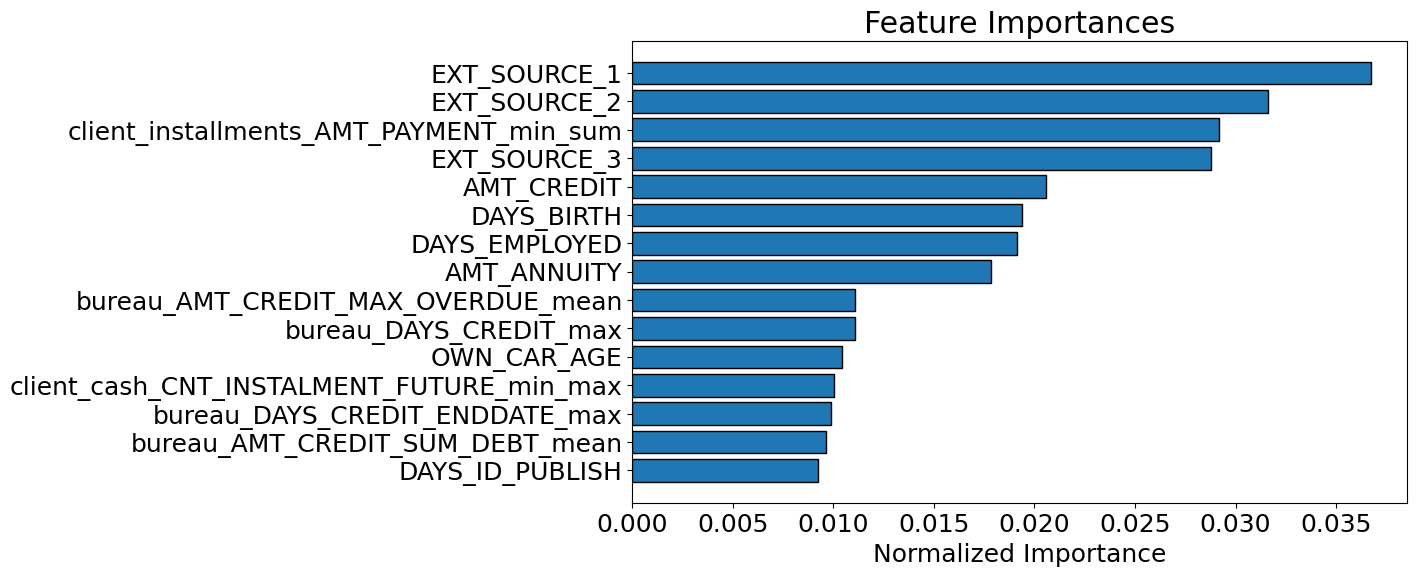

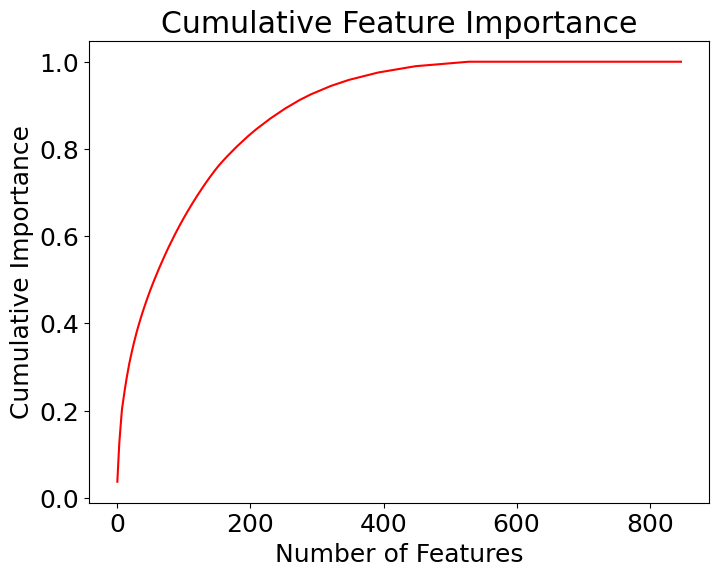

_____________________________________________________________________
262 features required for 0.90 of cumulative importance


,index,feature,importance,importance_normalized,cumulative_importance
0,28,EXT_SOURCE_1,141.0,0.036719,0.036719
1,29,EXT_SOURCE_2,121.5,0.031641,0.068359
2,847,client_installments_AMT_PAYMENT_min_sum,112.0,0.029167,0.097526
3,30,EXT_SOURCE_3,110.5,0.028776,0.126302
4,5,AMT_CREDIT,79.0,0.020573,0.146875
...,...,...,...,...,...
843,78,NAME_TYPE_SUITE_Other_B,0.0,0.000000,1.000000
844,77,NAME_TYPE_SUITE_Other_A,0.0,0.000000,1.000000
845,232,bureau_AMT_CREDIT_SUM_OVERDUE_min,0.0,0.000000,1.000000
846,76,NAME_TYPE_SUITE_Group of people,0.0,0.000000,1.000000


In [78]:
plot_feature_importances(feature_importances, threshold = 0.9)

In [79]:
print('There are %d features with 0.0 importance' % len(zero_features))

There are 320 features with 0.0 importance


In [80]:
train_small = df_app_train.drop(columns = zero_features)
test_small = df_app_test.drop(columns = zero_features)

print('Training shape: ', train_small.shape)
print('Testing shape: ', test_small.shape)

Training shape:  (307511, 529)
Testing shape:  (48744, 528)


In [81]:
zero_features, feature_importances = identify_zero_importance_features(train_small)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.484400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74041
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 528
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set dat

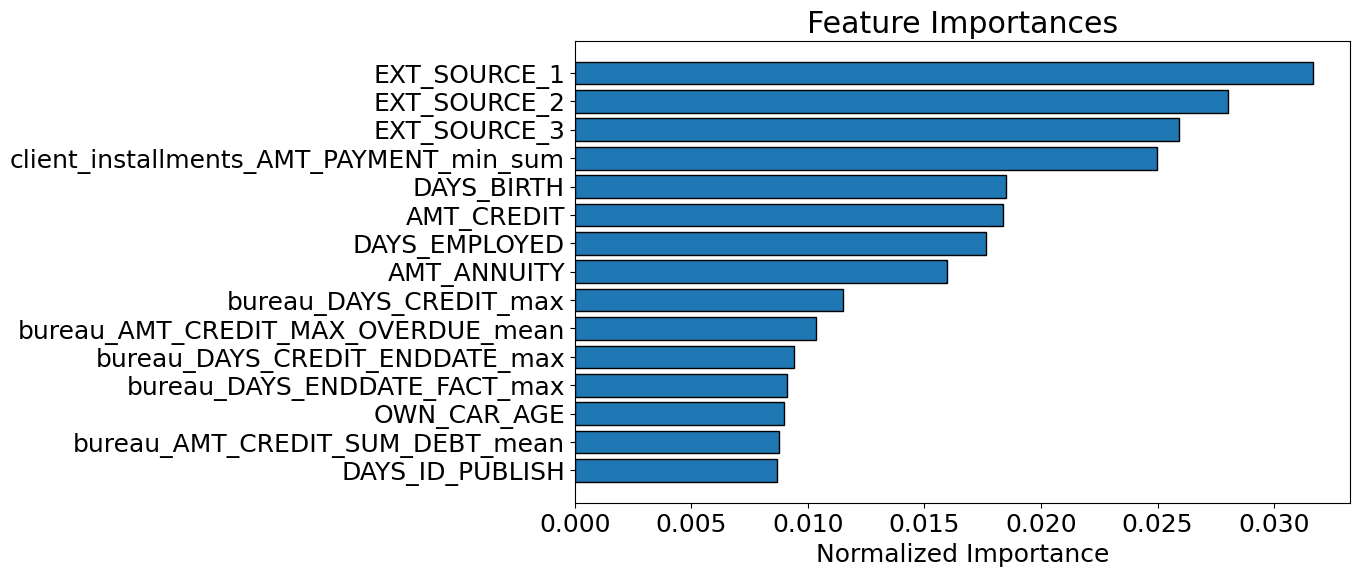

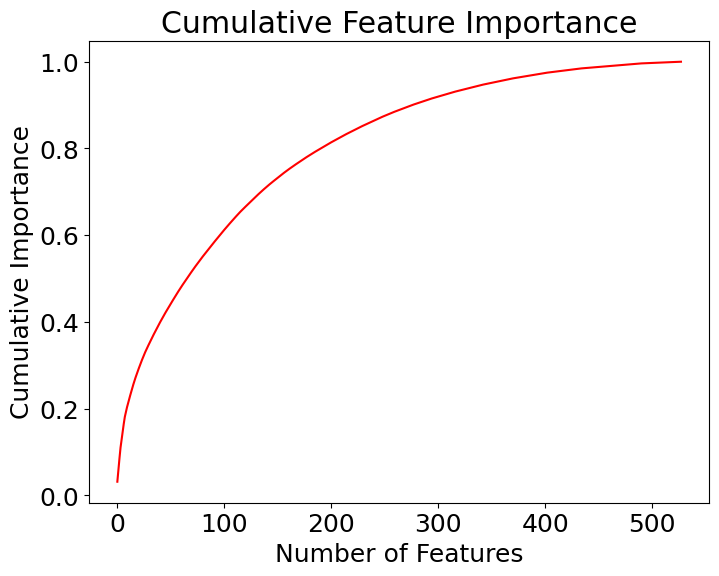

_____________________________________________________________________
349 features required for 0.95 of cumulative importance


In [82]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [83]:
threshold = 0.95

features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

train_small = train_small[features_to_keep]
test_small = test_small[features_to_keep]

print('Training shape: ', train_small.shape)
print('Testing shape: ', test_small.shape)

Training shape:  (307511, 348)
Testing shape:  (48744, 348)


In [84]:
train_small['TARGET'] = df_app_train['TARGET']
#train_small['SK_ID_CURR'] = df_app_train['SK_ID_CURR']
#test_small['SK_ID_CURR'] = df_app_test['SK_ID_CURR']

print('Training shape: ', train_small.shape)
print('Testing shape: ', test_small.shape)

Training shape:  (307511, 349)
Testing shape:  (48744, 348)


Nous sommes passé de ~1760 feature à ~350 features en ne selectionnant que les features qui compte pour 95% des l'importance du modele que nous avons choisis. Ce qui est une très bonne chose !  
Nous allons maintenant sauvegarder ce dont nous avons besoin pour notre prochain notebook sur la modélisation.

In [85]:
if not os.path.exists('df_engineered_selected') :
    os.mkdir('df_engineered_selected')

train_small.to_csv('df_engineered_selected/df_app_train_small.csv', index = False)
test_small.to_csv('df_engineered_selected/df_app_test_small.csv', index = False)

#### Note :
> D'autres possibilités de réductions de features (dimensions) auraient été possible :
>   - PCA
>   - ICA
>   - Manifold learning see non-linear dimensionality reduction : https://stats.stackexchange.com/questions/247907/what-is-the-difference-between-manifold-learning-and-non-linear-dimensionality-r
>
> Tout ce qui est analyse de composants obscurciraient l'explication des features. Importantes dans notre cas.  
> 'Manifold learning' n'est pas déterministe, et non applicable avec de nouvelles données.